In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


In [2]:
# Custom function to load and parse data
def load_data(filename, is_train=True):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(' ::: ')
            if is_train:
                data.append((parts[2], parts[3]))  # (genre, text)
            else:
                data.append((parts[1], parts[2]))  # (title, text)
    return pd.DataFrame(data, columns=['genre', 'text']) if is_train else pd.DataFrame(data, columns=['title', 'text'])


In [3]:
# Load train data
train_data = load_data('train_data.txt', is_train=True)


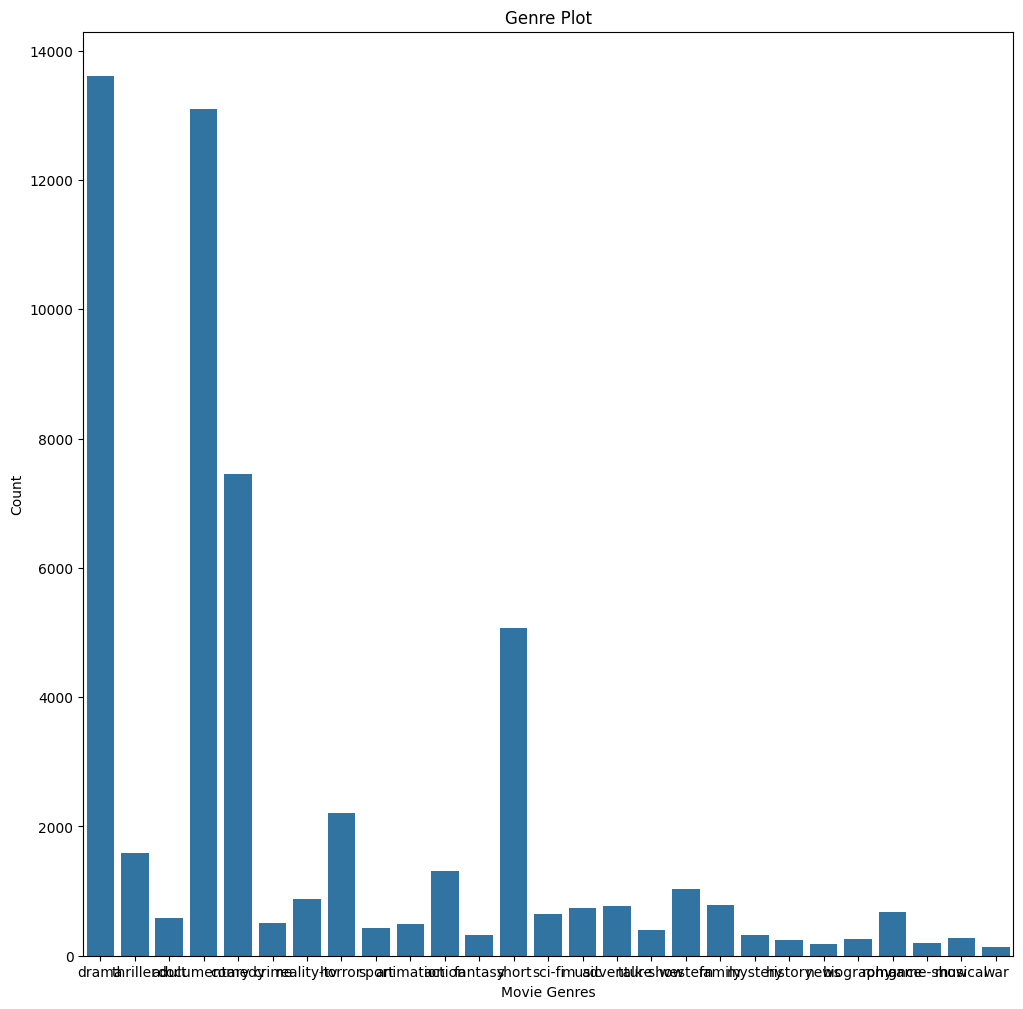

In [4]:
# Visualize genre counts
plt.figure(figsize=(12, 12))
sns.countplot(x='genre', data=train_data)
plt.xlabel('Movie Genres')
plt.ylabel('Count')
plt.title('Genre Plot')
plt.show()

In [5]:
# Mapping genres to numerical values
genre_mapper = {'other': 0, 'action': 1, 'adventure': 2, 'comedy': 3, 
                'drama': 4, 'horror': 5, 'romance': 6, 'sci-fi': 7, 'thriller': 8, 'documentary': 9, 'adult': 10}

train_data['genre'] = train_data['genre'].map(genre_mapper)


In [6]:
# Initialize the PorterStemmer
ps = PorterStemmer()


In [7]:
# Create the stopwords set once
stop_words = set(stopwords.words('english'))


In [8]:
# Define a function to preprocess a single document
def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text)
    # Convert to lower case
    text = text.lower()
    # Split into words
    words = text.split()
    # Remove stopwords and stem the words
    words = [ps.stem(word) for word in words if word not in stop_words]
    # Join the words back into a single string
    return ' '.join(words)


In [9]:
# Preprocess text data
train_data['text'] = train_data['text'].apply(preprocess_text)


In [10]:
# Creating the Bag of Words model using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(train_data['text']).toarray()
y = train_data['genre'].values


In [11]:
# Handle NaN values in y by imputing
imputer = SimpleImputer(strategy='mean')
y_imputed = imputer.fit_transform(y.reshape(-1, 1)).ravel()


In [12]:
# Model Building
X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))


X_train size: (43371, 10000), X_test size: (10843, 10000)


In [14]:
# Convert labels to integers
y_train = y_train.astype(int)

# Fitting Naive Bayes to the Training set
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)


MultinomialNB()

In [15]:
# Predicting the Test set results
nb_y_pred = nb_classifier.predict(X_test)

In [17]:
print("Data type of y_test:", y_test.dtype)
print("Data type of nb_y_pred:", nb_y_pred.dtype)


Data type of y_test: float64
Data type of nb_y_pred: int32


In [18]:
print("Shape of y_test:", y_test.shape)
print("Shape of nb_y_pred:", nb_y_pred.shape)


Shape of y_test: (10843,)
Shape of nb_y_pred: (10843,)


In [19]:
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in nb_y_pred:", np.unique(nb_y_pred))


Unique values in y_test: [ 1.          2.          3.          4.          5.          5.61933254
  6.          7.          8.          9.         10.        ]
Unique values in nb_y_pred: [ 1  2  3  4  5  8  9 10]


Unique labels in y_test: [ 1.          2.          3.          4.          5.          5.61933254
  6.          7.          8.          9.         10.        ]
Unique labels in nb_y_pred: [ 1  2  3  4  5  8  9 10]


In [21]:
# Convert y_test to integer type
y_test = y_test.astype(int)

# Now calculate the accuracy score
accuracy = accuracy_score(y_test, nb_y_pred)
print("Accuracy score is: {}%".format(round(accuracy * 100, 2)))


Accuracy score is: 57.47%


In [25]:
# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, nb_y_pred, labels=np.unique(y_test), target_names=genre_mapper.keys(), zero_division=1))


Classification Report:
              precision    recall  f1-score   support

       other       0.50      0.00      0.01       248
      action       0.78      0.05      0.09       150
   adventure       0.70      0.31      0.43      1497
      comedy       0.54      0.75      0.63      2773
       drama       0.50      0.55      0.53      2895
      horror       1.00      0.00      0.00       121
     romance       1.00      0.00      0.00       139
      sci-fi       1.00      0.01      0.01       324
    thriller       0.66      0.80      0.73      2586
 documentary       0.67      0.02      0.04       110

    accuracy                           0.57     10843
   macro avg       0.73      0.25      0.25     10843
weighted avg       0.61      0.57      0.54     10843



C:\Users\zatch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2608: UserWarning: labels size, 10, does not match size of target_names, 11
  warnings.warn(


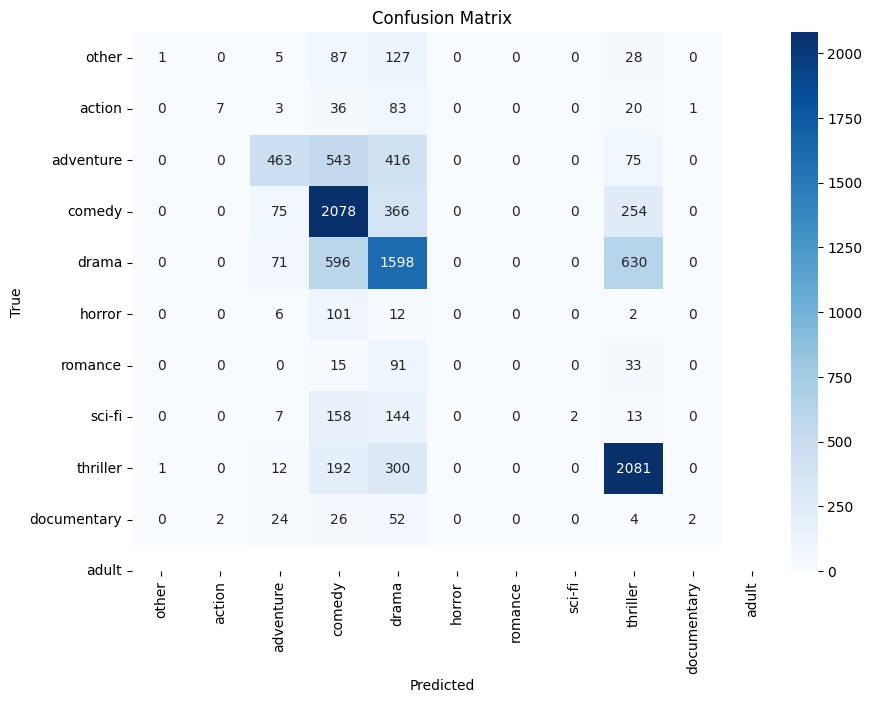

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, nb_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_mapper.keys(), yticklabels=genre_mapper.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Save TF-IDF Vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save Naive Bayes Model
with open('model.pkl', 'wb') as f:
    pickle.dump(nb_classifier, f)